In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import configparser
import os  # Import os library for path operations

import seaborn as sns
sns.set_theme(style="darkgrid")

# Read configuration from config.ini
config = configparser.ConfigParser()
config.read('config.ini')


['config.ini']

In [9]:
def prepare_data(file_path):
    """
    Read CSV file and perform necessary preprocessing.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """

    # Ensure the file path exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Define data types and index column
    data_types = {
        'ds': 'str',
        'unique_id': 'category',
        'y': np.int64
    }
    index_col = 'ds'

    # Read CSV with specified data types and index
    df = pd.read_csv(file_path, dtype=data_types, parse_dates=[index_col])

    # Check if 'ds' is present in the columns
    if 'ds' not in df.columns:
        raise KeyError("The 'ds' column is not present in the DataFrame.")

    # Convert 'ds' column to datetime after reading
    df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m')  # Adjust the format based on your actual data
    
    df = df[['unique_id', 'ds', 'y']]
    
    return df

In [10]:
df_path = config['Paths']['dataset_data']

df = prepare_data(df_path)
df.head(), df.shape

(  unique_id         ds   y
 0      0101 2018-01-01   0
 1      0101 2018-02-01  20
 2      0101 2018-03-01   1
 3      0101 2018-04-01  40
 4      0101 2018-05-01   6,
 (2829, 3))

<Axes: xlabel='ds', ylabel='y'>

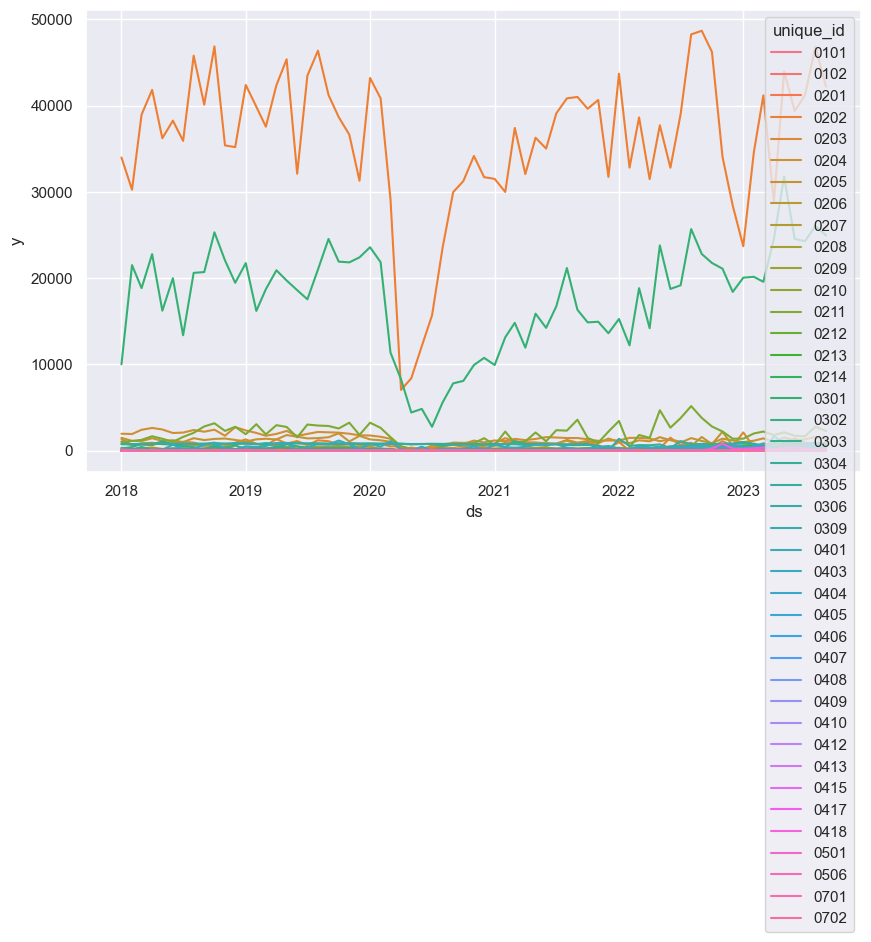

In [21]:

# Visualize the original time series
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="ds", y="y",
    hue="unique_id", 
    # style="unique_id",
    data=df    
)

<Axes: xlabel='ds', ylabel='y'>

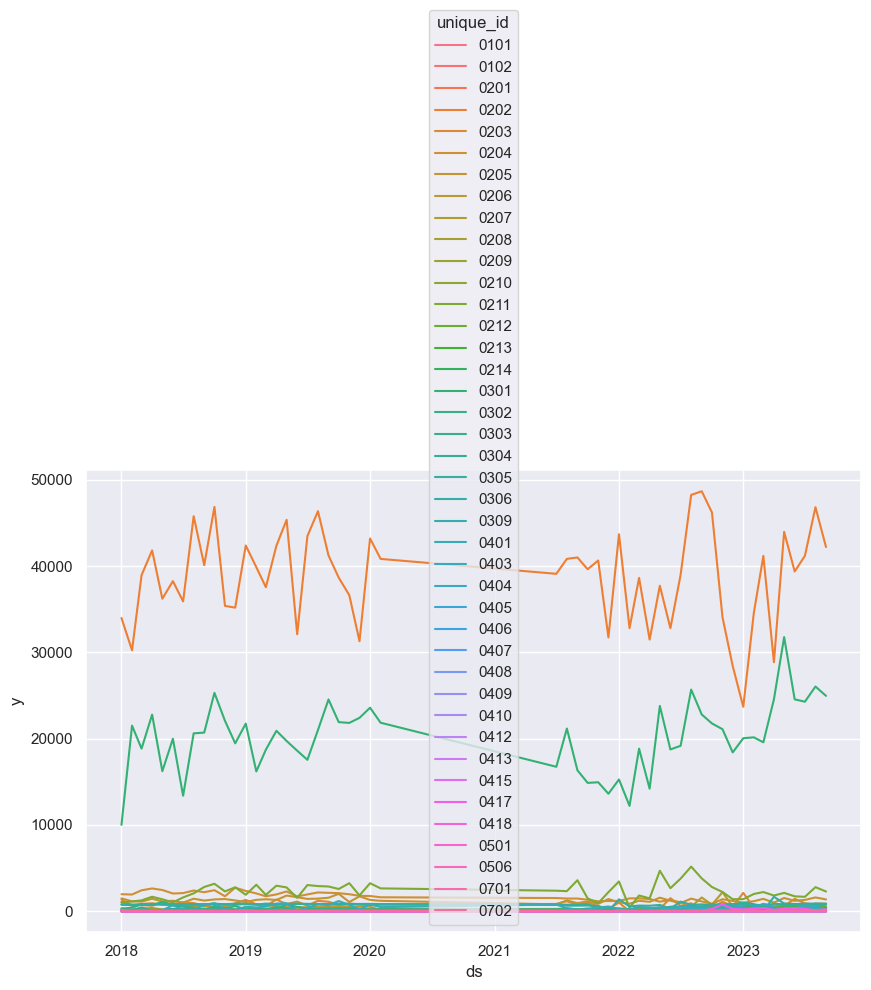

In [23]:
# Identify and remove the COVID-19 period
covid_start_date = pd.to_datetime('2020-03-01')
covid_end_date = pd.to_datetime('2021-06-01')
df = df.loc[~((df['ds'] >= covid_start_date) & (df['ds'] <= covid_end_date))]

# Visualize the final time series
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="ds", y="y",
    hue="unique_id", 
    # style="unique_id",
    data=df, 
    legend="off"
)


In [24]:
from statsforecast.models import (
    AutoARIMA,
    AutoETS
)
from statsforecast import StatsForecast

models= [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12)
]

# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=df, 
    models=models,
    freq='MS', 
    n_jobs=-1
)

c:\Users\brvn\AppData\Local\anaconda3\envs\meutcc\Lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [25]:
forecast_df = sf.forecast(h=12, level=[80])
forecast_df.head()

,ds,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoETS,AutoETS-lo-80,AutoETS-hi-80
unique_id,,,,,,,
0101,2023-10-01,259.580688,183.522385,335.638977,402.263275,339.728088,464.798462
0101,2023-11-01,432.216431,346.117035,518.315796,421.937012,358.716248,485.157745
0101,2023-12-01,413.359436,322.695770,504.023071,441.610748,375.720825,507.500641
0101,2024-01-01,414.557312,312.208130,516.906494,461.284485,389.753418,532.815552
0101,2024-02-01,429.194763,318.163971,540.225586,480.958221,400.368561,561.547852


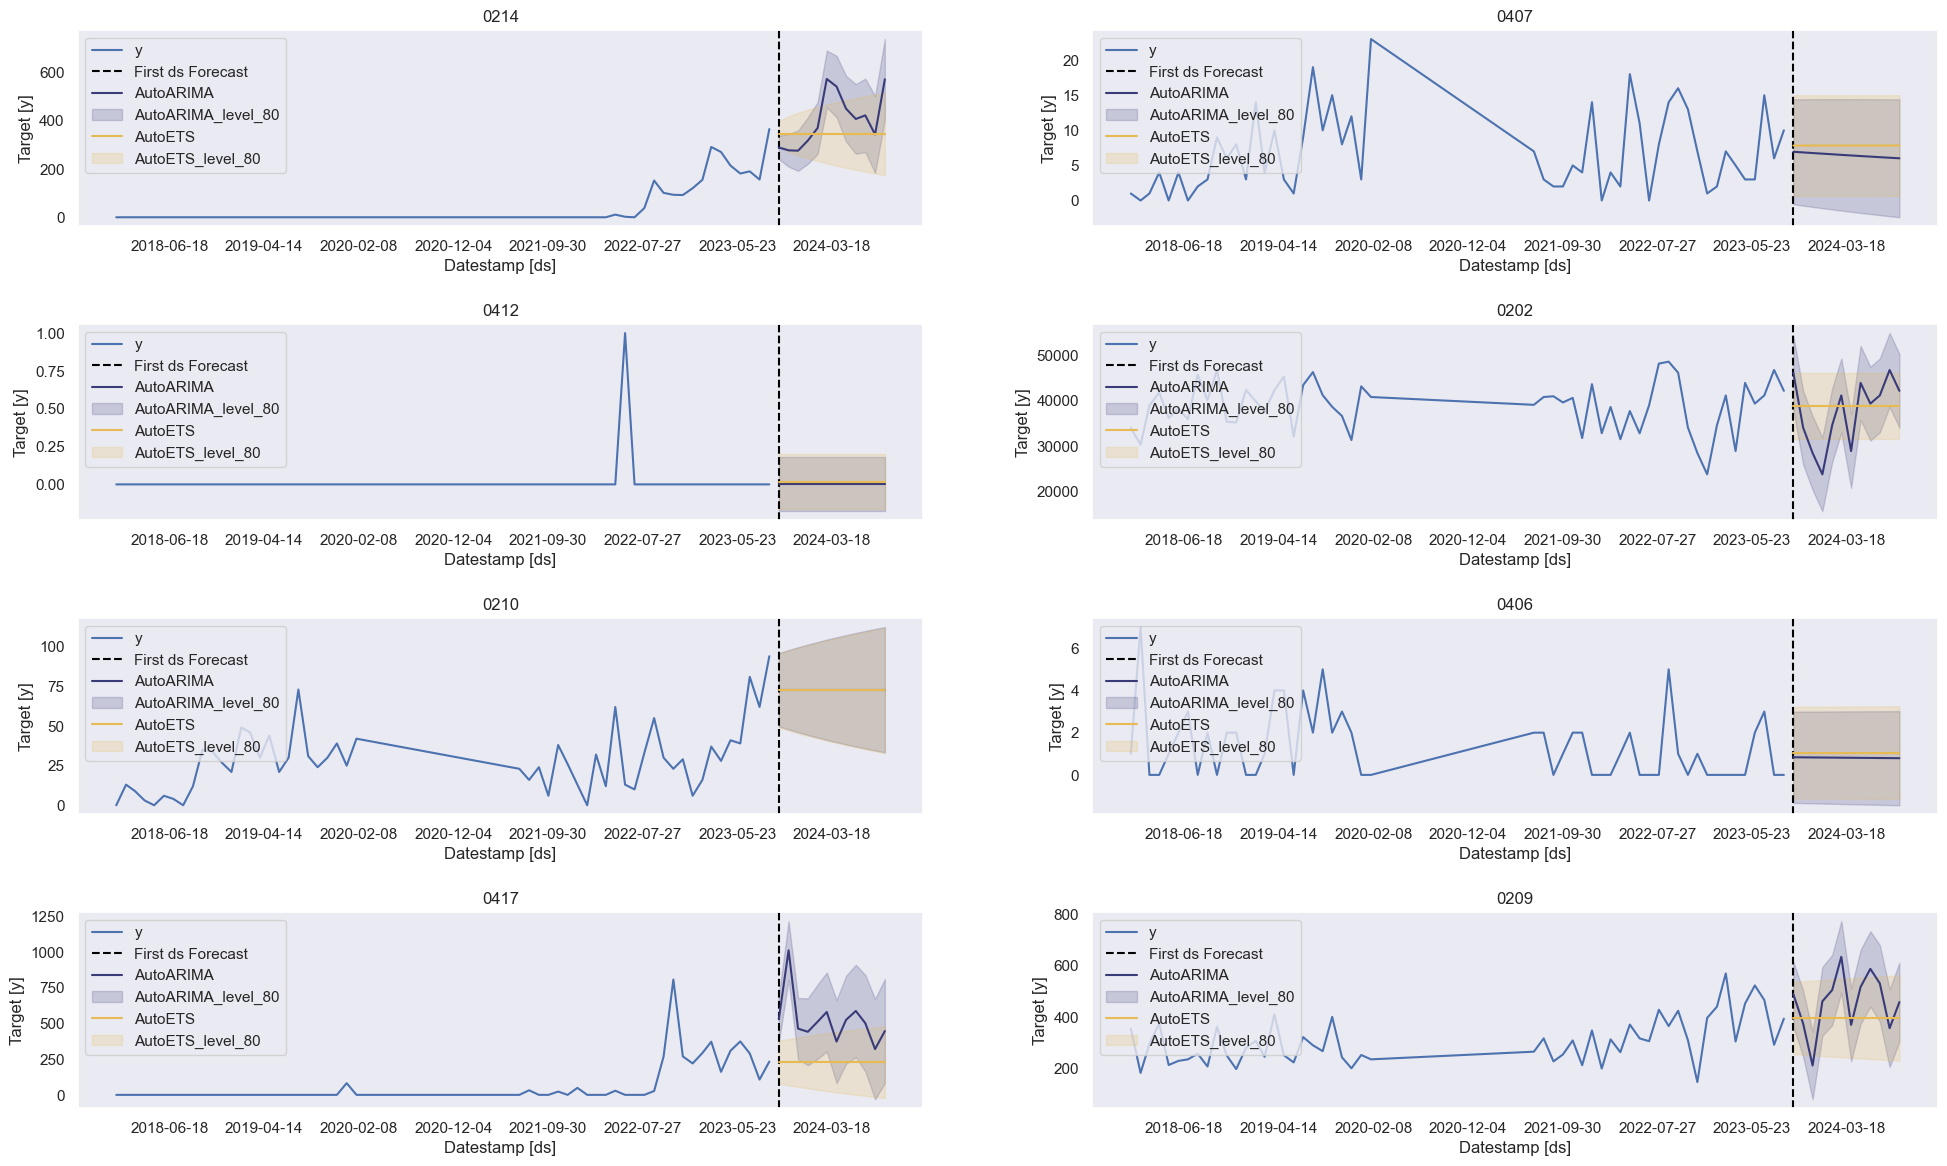

In [26]:
sf.plot(df, forecast_df, engine='matplotlib')

In [28]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=12,
    step_size=12,
    n_windows=1
  )

In [29]:
crossvaldation_df.head()

,ds,cutoff,y,AutoARIMA,AutoETS
unique_id,,,,,
0101,2022-10-01,2022-09-01,7.0,7.871299,7.038554
0101,2022-11-01,2022-09-01,136.0,6.341195,7.038554
0101,2022-12-01,2022-09-01,142.0,19.952103,7.038554
0101,2023-01-01,2022-09-01,148.0,6.146776,7.038554
0101,2023-02-01,2022-09-01,151.0,6.103419,7.038554


In [32]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id', observed=False).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [33]:
evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(), mse)

evaluation_df.head()

,AutoARIMA,AutoETS,best_model
unique_id,,,
0101,4.485030e+04,4.678029e+04,AutoARIMA
0102,8.333334e-02,6.040856e-04,AutoETS
0201,1.185625e+04,4.345748e+03,AutoETS
0202,5.376021e+07,5.480491e+07,AutoARIMA
0203,3.765349e+05,2.450448e+05,AutoETS


In [34]:
#Criando um sumário dos melhores modelos
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()

summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

# autoets_ids = evaluation_df.query('best_model == "AutoETS"').index
# autoarima_ids = evaluation_df.query('best_model == "AutoARIMA"').index

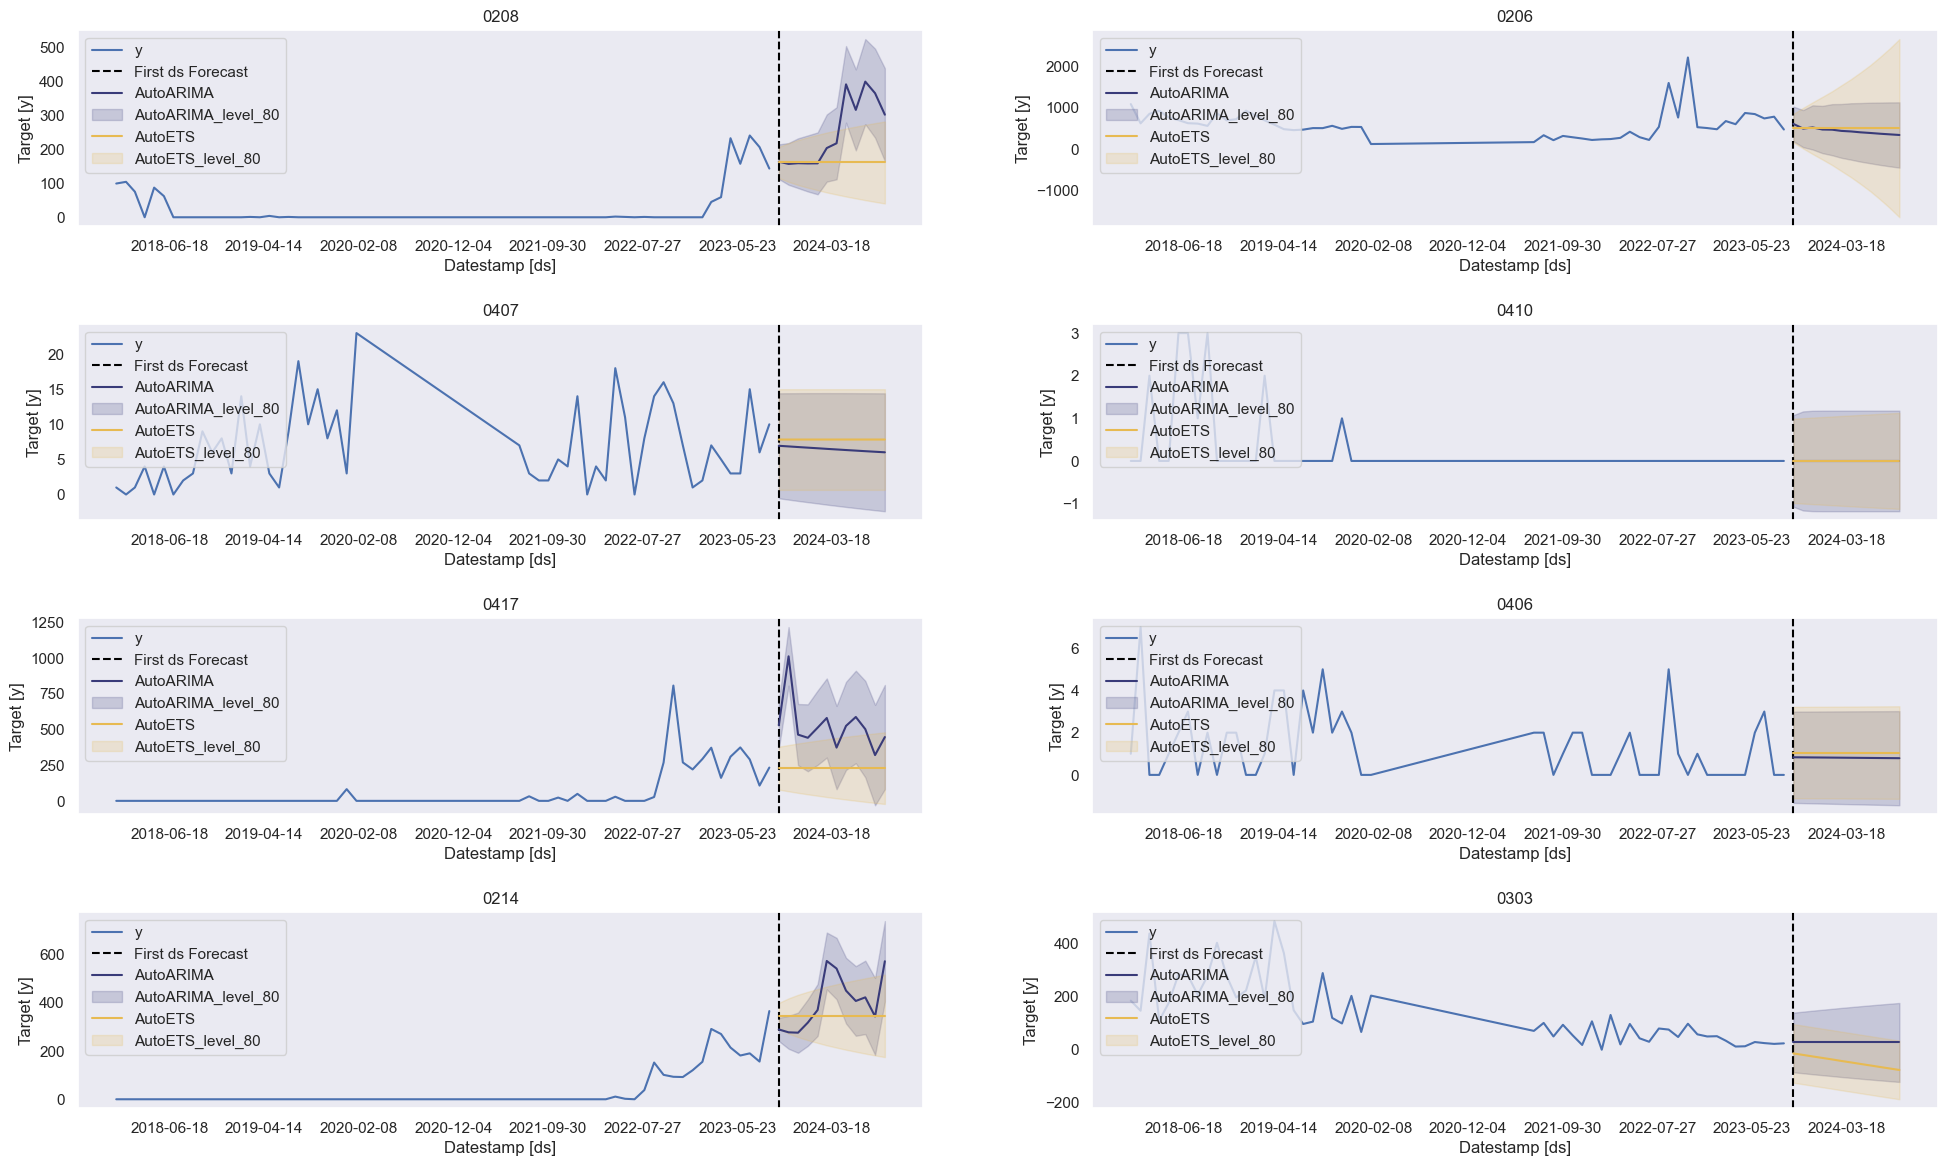

In [35]:
autoarima_ids = evaluation_df.query('best_model == "AutoARIMA"').index
sf.plot(df=df,forecasts_df=forecast_df, unique_ids=autoarima_ids, engine='matplotlib')

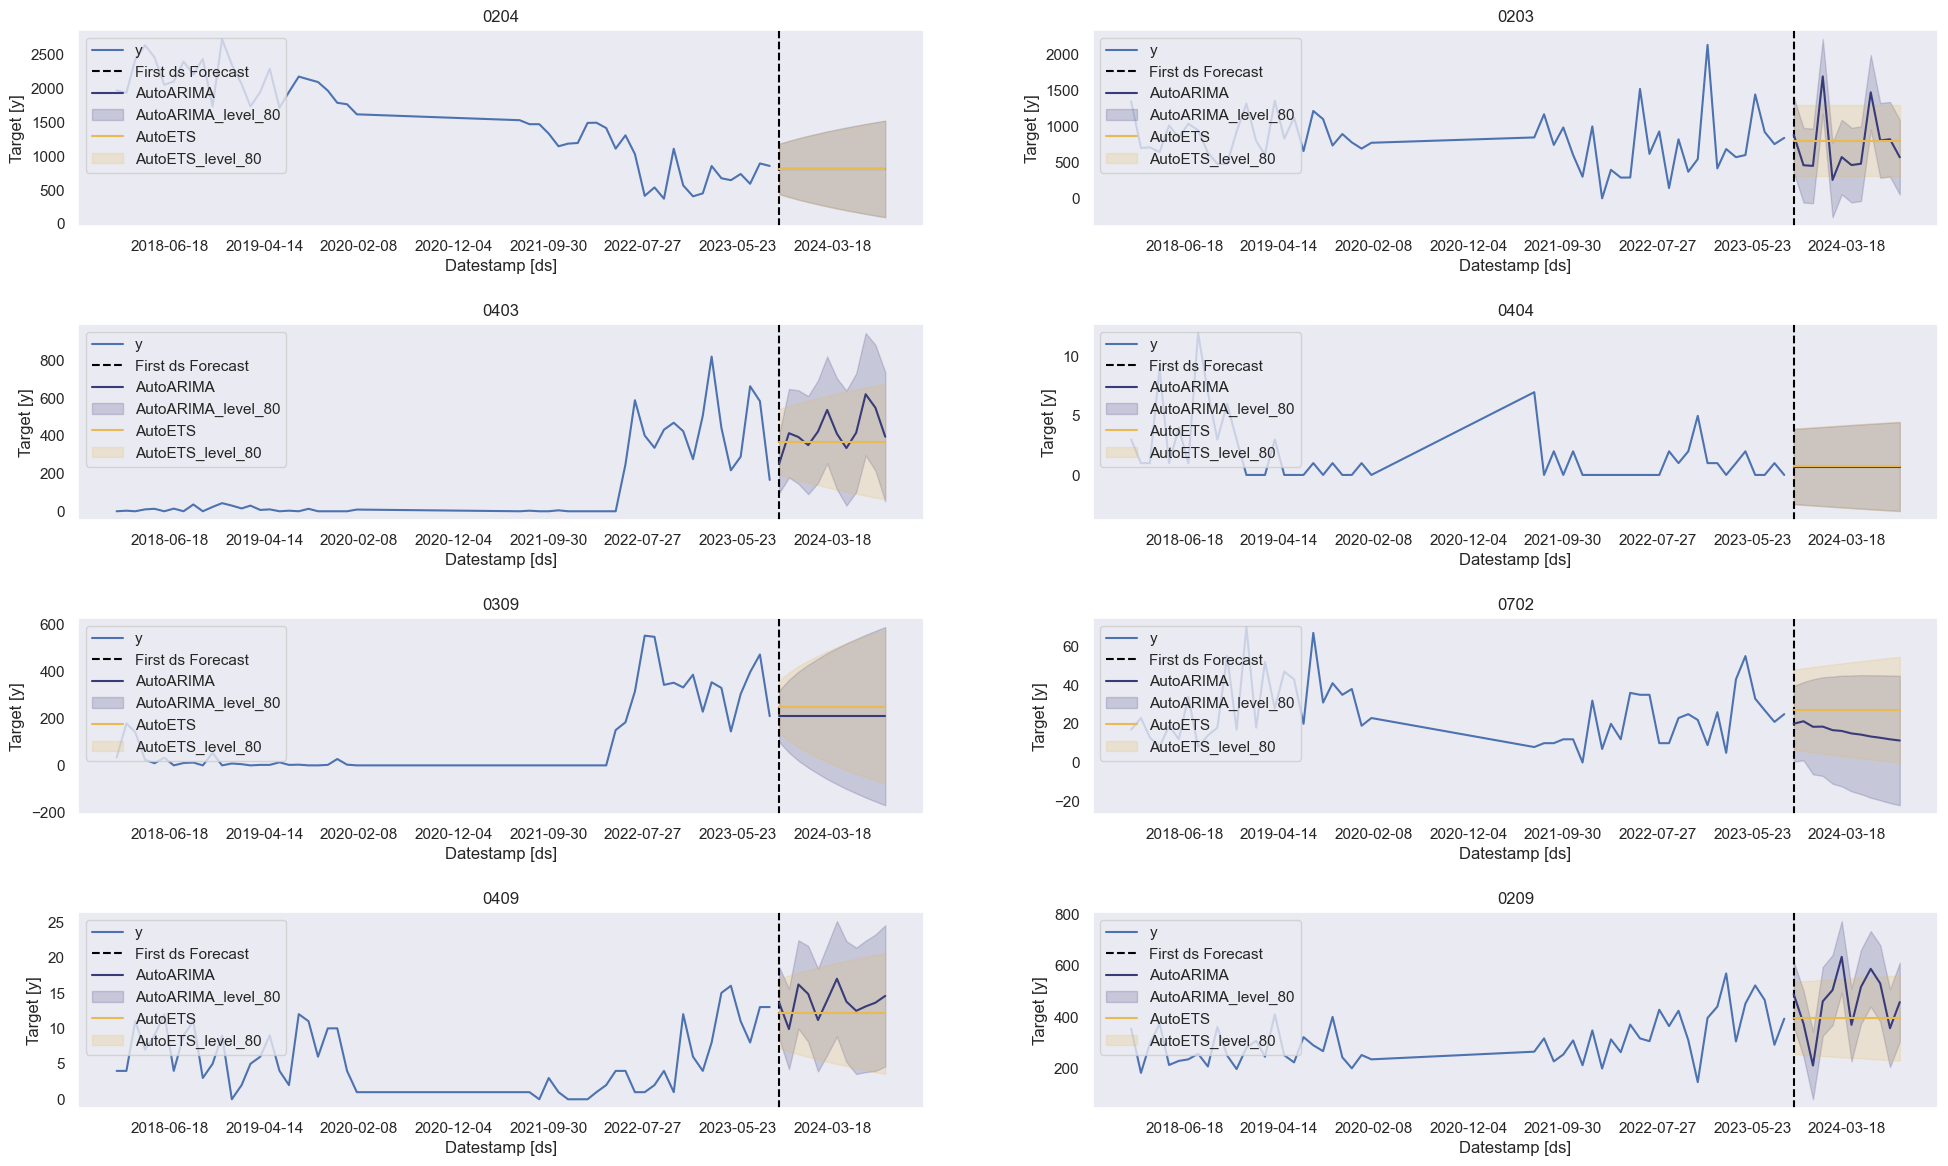

In [36]:
autoets_ids = evaluation_df.query('best_model == "AutoETS"').index
sf.plot(df=df, forecasts_df=forecast_df, unique_ids=autoets_ids, engine='matplotlib')

In [37]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df

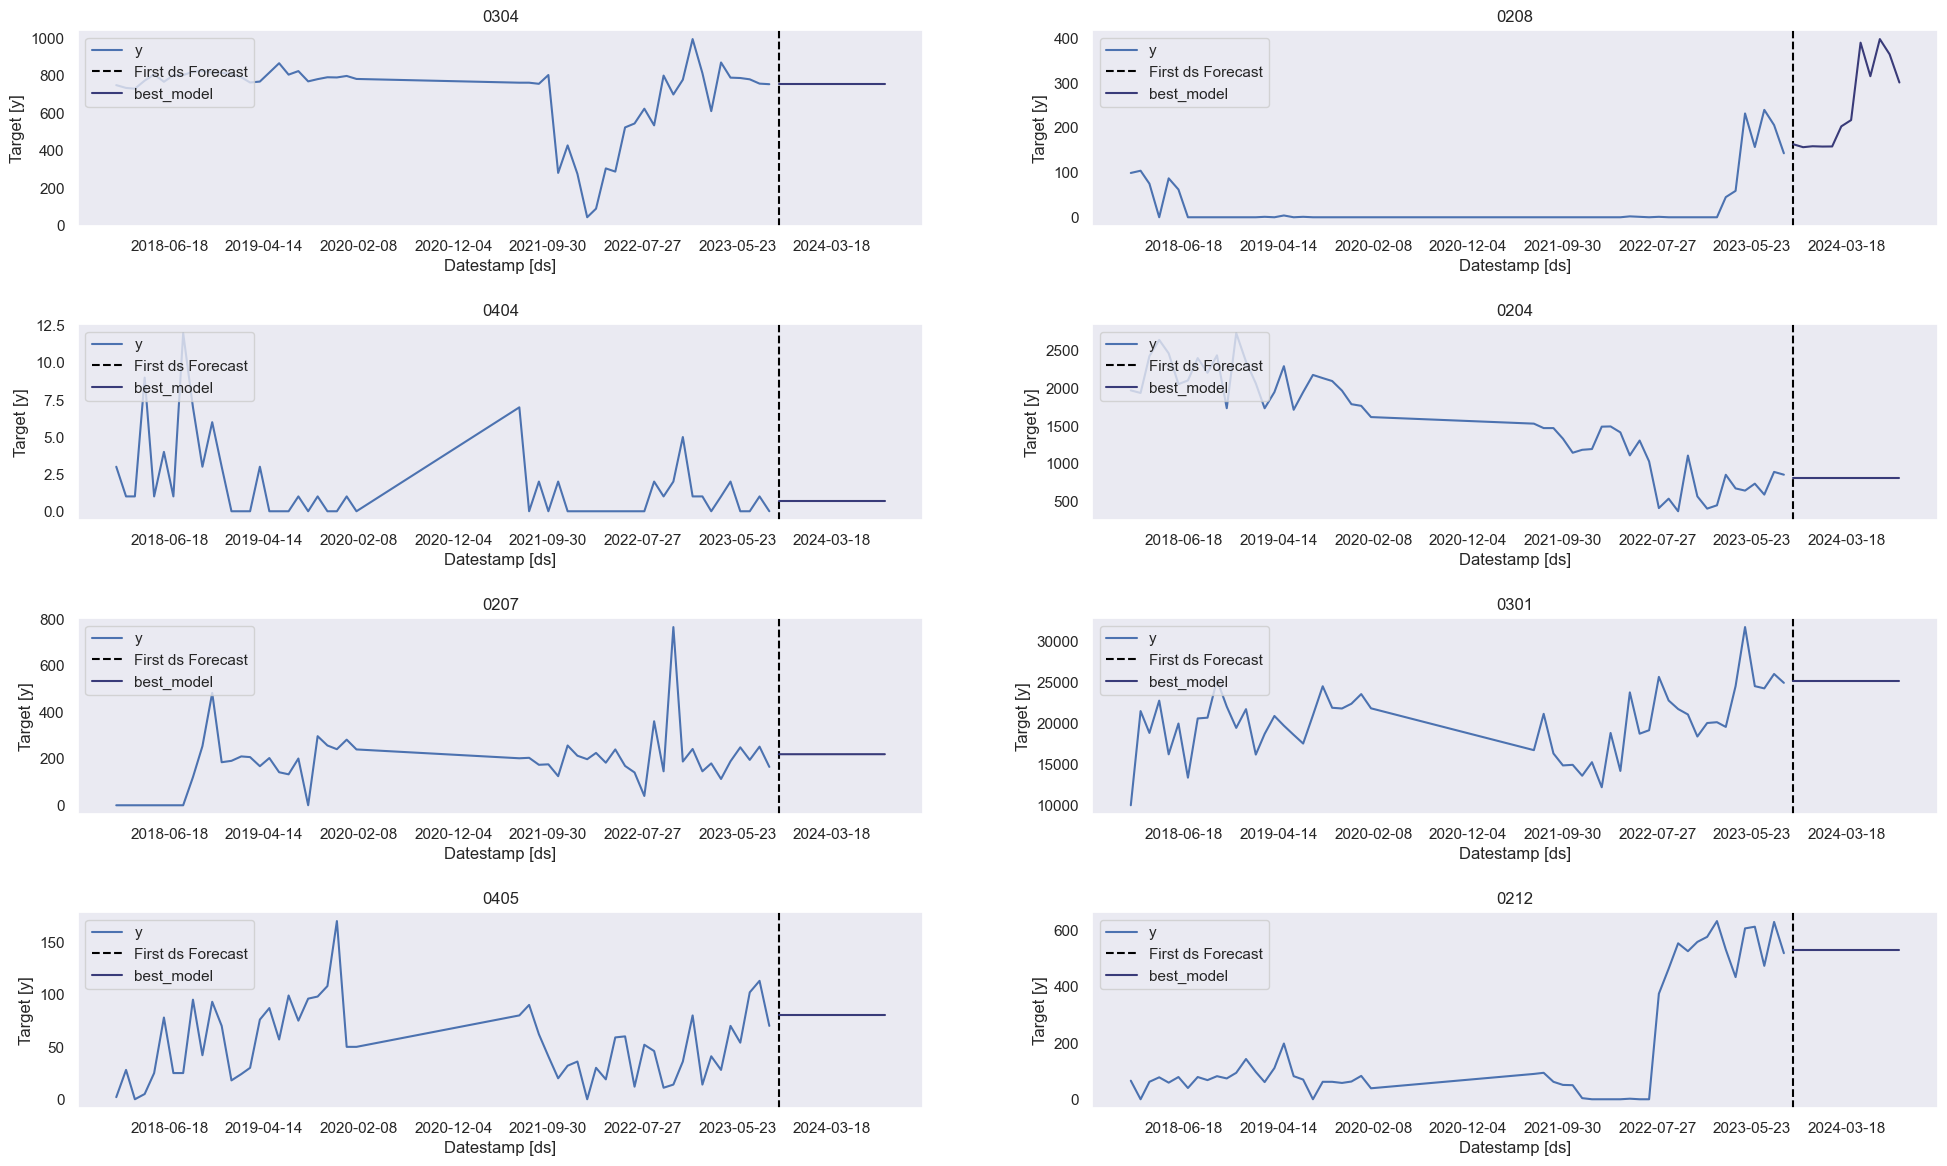

In [38]:
prod_forecasts_df = get_best_model_forecast(forecast_df, evaluation_df)
sf.plot(df, prod_forecasts_df, level=[90], engine='matplotlib')

In [39]:
prod_forecasts_df.to_csv("covid-forecasted-df.csv", float_format="%d")

<Axes: xlabel='ds', ylabel='y'>

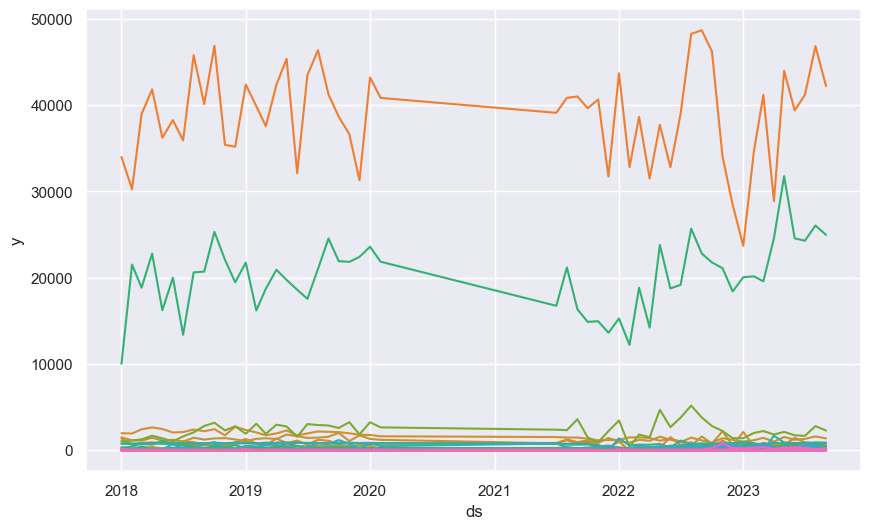

In [42]:
# Visualize the final time series
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="ds", y="y",
    hue="unique_id", 
    # style="unique_id",
    data=df, 
    legend=False
)